In [4]:
import numpy as np
from datasets import Dataset
from PIL import Image
import pathlib
from transformers import SamProcessor, SamModel, SamConfig
import torch
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import cv2

In [5]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def plt_result(result, img):
    plt.figure(figsize=(20,20))
    plt.imshow(img)
    plt.axis('off')
    show_anns(result)

def get_top_brightness_points(np_image, percentage):
    grayscale_image = np.mean(np_image, axis=2)
    threshold_value = np.percentile(grayscale_image, 100 - percentage)
    bright_areas_mask = grayscale_image > threshold_value
    return bright_areas_mask

def appl_exp(ori):
    exposure_factor = 18
    exposed_image_array = np.clip(ori * exposure_factor, 0, 65535)
    return exposed_image_array

def cluster_points(points, eps=5, min_samples=3):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    labels = db.labels_
    unique_labels = set(labels)
    clusters = [points[labels == k] for k in unique_labels if k != -1]
    return clusters

def get_bounding_box(points):
    min_x = np.min(points[:, 1])
    max_x = np.max(points[:, 1])
    min_y = np.min(points[:, 0])
    max_y = np.max(points[:, 0])
    return [min_x, min_y, max_x, max_y]

In [6]:
# Load image and model
target = pathlib.Path("./201-250_Hong/MAX_CTLa_w1-359 DAPI_s012.tif")
img_org = Image.open(target)
img = cv2.cvtColor(np.array(img_org), cv2.COLOR_GRAY2RGB).astype(np.float32)
device = "cuda" if torch.cuda.is_available() else "cpu"

CP = "fish_v2.1.pth"
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
model = SamModel(config=model_config)
model.load_state_dict(torch.load(pathlib.Path("./checkpoints/"+CP), map_location=torch.device('cpu')))
model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [7]:
# Load dataset and select an example image
idx = 10
dataset = Dataset.load_from_disk(pathlib.Path("./data"))
example_image = dataset[idx]["image"]
np_image = np.array(example_image)

In [8]:
# Get top brightness points mask
percentage = 30  # Percentage for top brightest points
bright_areas_mask = get_top_brightness_points(np_image, percentage)

In [9]:
# Convert bright points mask to coordinates
bright_points = np.column_stack(np.where(bright_areas_mask))

# Cluster the bright points
clusters = cluster_points(bright_points)

# Prepare the input points for each cluster
grouped_input_points = [cluster.tolist() for cluster in clusters]

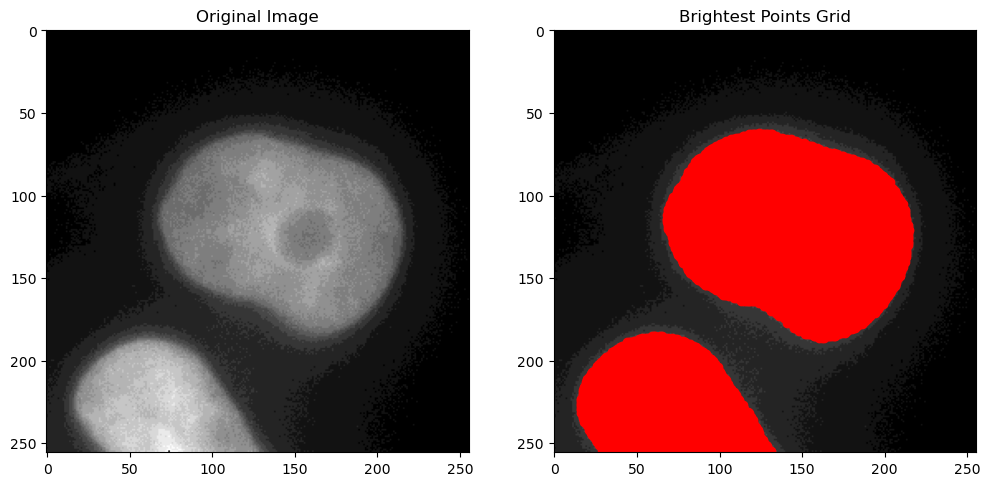

In [12]:
# Visualize the original image and the filtered grid points
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(appl_exp(np_image))

plt.subplot(1, 2, 2)
plt.title("Brightest Points Grid")
plt.imshow(appl_exp(np_image))
for cluster in grouped_input_points:
    for point in cluster:
        plt.plot(point[1], point[0], 'ro')  # Note: (x, y) format for plotting

plt.show()

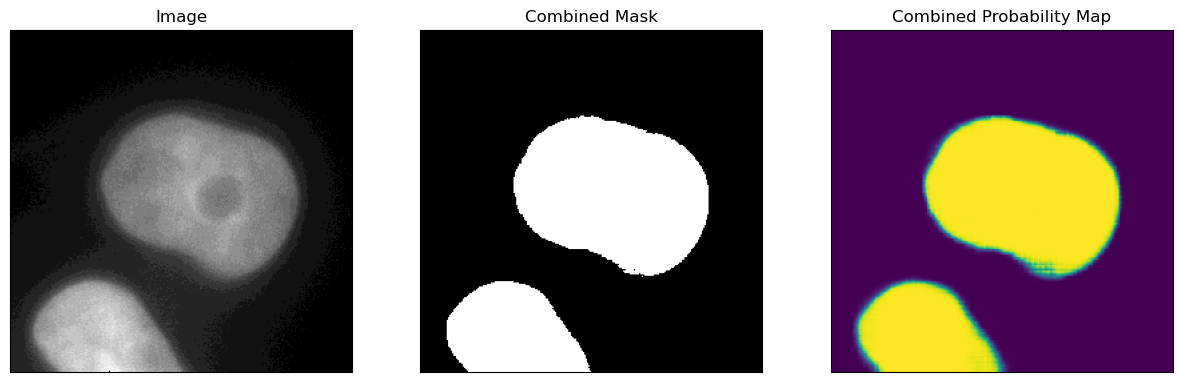

In [13]:
# Generate bounding boxes for each cluster
bounding_boxes = [get_bounding_box(np.array(cluster)) for cluster in grouped_input_points]

# Initialize combined masks
combined_masks = np.zeros_like(np_image[:, :, 0])
combined_probs = np.zeros_like(np_image[:, :, 0], dtype=np.float32)

# Use the bounding boxes to make predictions
for bbox in bounding_boxes:
    inputs = processor(example_image, input_boxes=[[bbox]], return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)

    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    combined_masks = np.maximum(combined_masks, medsam_seg)
    combined_probs = np.maximum(combined_probs, medsam_seg_prob)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(appl_exp(np.array(example_image)), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the combined mask in the middle
axes[1].imshow(combined_masks, cmap='gray')
axes[1].set_title("Combined Mask")

# Plot the combined probability map on the right
axes[2].imshow(combined_probs)
axes[2].set_title("Combined Probability Map")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()
